# Import

In [1]:
import glob
import os
import sys
import random
import time
import numpy as np
import cv2
import math
from collections import deque
from keras.models import Sequential
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.models import model_from_json
import pandas as pd
from plotnine import *
#from keras.callbacks import TensorBoard

import tensorflow as tf
import keras.backend.tensorflow_backend as backend
from threading import Thread
from tqdm import tqdm_notebook as tqdm

try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass
import carla
print('IMPORT DONE')

Using TensorFlow backend.


IMPORT DONE


# Carla Env

In [2]:
class CarEnv:
    global town
    #BRAKE_AMT = 1.0
    actor_list = []
    collision_hist = []
    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)
        world = self.client.load_world(town)
        self.world = self.client.get_world()
        blueprint_library = self.world.get_blueprint_library()
        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
        self.place=0
        
    def Black_screen(self):
        settings = self.world.get_settings()
        settings.no_rendering_mode = True
        self.world.apply_settings(settings)
    
    def set_location(self,x,y):
        
        self.lo_x,self.lo_y=x,y
        self.place=x,y
        
                     
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []
        ##print('Location: ',str(place))
        #transform = carla.Transform(carla.Location(-120,place,3),carla.Rotation(0,-90,0))
        if self.place == 0:
            transform = carla.Transform(carla.Location(246,-36,3),carla.Rotation(0,-90,0))  
        else :
            transform = carla.Transform(carla.Location(self.lo_x,self.lo_y),carla.Rotation(0,-90,0))  
            
        self.flag = 0
        self.vehicle = self.world.spawn_actor(self.model_3, transform)
        self.flag = 1
        
        self.actor_list.append(self.vehicle)
     

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')
        
        transform = carla.Transform(carla.Location(x=0, z=1.9))
        time.sleep(0.01)

        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)
     
        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=0, brake=0.0))
        self.episode_start = time.time()
   
        time.sleep(0.4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle_f is None:
            time.sleep(0.01)

        self.episode_start = time.time()
        
        self.vehicle.apply_control(carla.VehicleControl(throttle=0, brake=0.0))
        
        ##SENSOR LIDAR
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz])
        
        return state_

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        
        lidar_f = lidar_line(points,90,2)
        lidar_r = lidar_line(points,45,2)
        lidar_l = lidar_line(points,135,2)

        if len(lidar_f) == 0:
            pass
        else:
            self.distance_to_obstacle_f = min(lidar_f[:,1])-2.247148275375366
        
        if len(lidar_r) == 0:
            pass
        else:
            self.distance_to_obstacle_r = np.sqrt(min(lidar_r[:,0]**2 + lidar_r[:,1]**2))
        
        if len(lidar_l) == 0:
            pass
        else:
            self.distance_to_obstacle_l = np.sqrt(min(lidar_l[:,0]**2 + lidar_l[:,1]**2))
    

    def step(self, action):
        global sleepy,steer_amt
        
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = steer_amt))
            time.sleep(sleepy)
            reward = 1
        elif action == 1:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = -steer_amt))
            time.sleep(sleepy)
            reward = 1       

        
        if len(self.collision_hist) != 0:
            done = True
        else :
            done=False
            
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz])
            
        return state_, reward, done, None
    
    def test_step_steer(self,steer,sleepy):
        
        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = steer))
        time.sleep(sleepy)
        reward = 1
        
        if len(self.collision_hist) != 0:
            done = True
        else :
            done=False
        
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz])
            
        return state_, reward, done, None
    
    def test_step_brake(self,sleepy):
        
        self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = steer))
        time.sleep(sleepy)
        reward = 1
        
        if len(self.collision_hist) != 0:
            done = True
        else :
            done=False
        
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            
        xx = self.distance_to_obstacle_f
        yy = self.distance_to_obstacle_r
        zz = self.distance_to_obstacle_l
        state_=np.array([xx,yy,zz])
            
        return state_, reward, done, None
        

# DQN Agent

In [3]:
class DQNAgent:
    
    def __init__(self,state_size,action_size):
        self.state_size=state_size
        self.action_size=action_size
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        self.target_update_counter = 0
        #self.graph = tf.get_default_graph()

        self.terminate = False
        self.last_logged_episode = 0
        self.training_initialized = False
    
    def get_weight(self):
        
        w = self.model.get_weights()        
        return w
    
    def predict(self,state):
        
        predict = self.model.predict(state.reshape((1, self.state_size)))
        return predict
    
    def save_model(self,name):
        model_json = self.model.to_json()
        with open("{}.json".format(name), "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights("{}.h5".format(name))
        print("Saved model to disk")     
        

    def create_model(self):
        
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, input_dim=32, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear'))            # output nodes = #action
        model.compile(loss='mse', optimizer=Adam(lr=0.01))
        return model

    def update_replay_memory(self, transition):
        # transition = (current_state, action, reward, new_state, done)
        self.replay_memory.append(transition)

    def train(self):
        global Loss
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            self.terminate=True
            Loss.append(0)
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
        
        current_states = np.array([transition[0] for transition in minibatch])
        
        #with self.graph.as_default():
        current_qs_list = self.model.predict(current_states, PREDICTION_BATCH_SIZE)

        new_current_states = np.array([transition[3] for transition in minibatch])
        
        #with self.graph.as_default():
        future_qs_list = self.target_model.predict(new_current_states, PREDICTION_BATCH_SIZE)

        X = []
        y = []

        for index, (current_state, action, reward, new_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            current_qs[action] = new_q
            
            X.append(current_state)
            y.append(current_qs)


        history=self.model.fit(np.array(X), np.array(y), batch_size=TRAINING_BATCH_SIZE, verbose=0, shuffle=False)
        history
        Loss.append(history.history['loss'][0])
        self.target_model.set_weights(self.model.get_weights())

    def get_qs(self, state):
        return self.model.predict(state.reshape((1, self.state_size)))[0]
        
    def train_in_loop(self):
        X = np.random.uniform(size=(1, self.state_size)).astype(np.float32)
        y = np.random.uniform(size=(1, self.action_size)).astype(np.float32)
        
        self.model.fit(X,y, verbose=False, batch_size=1)

        self.training_initialized = True
        print('Start Train')
        while True:
            if self.terminate:
                return
            self.train()
            time.sleep(0.01)

# Optional function

In [4]:
def open_carla(require):
    try:
        if require == 'fast':
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe -benchmark  -fps=10 -quality-level=Low')
        else:
            os.popen('C:\\Users\\nbhah\\Desktop\\Carla\\CarlaUE4\\Binaries\\Win64\\CarlaUE4.exe')
    except Exception as err:
        print(err)
    print('opening Carla')
    
def close_carla():
    try:
        os.system('TASKKILL /F /IM CarlaUE4.exe')
    except Exception as err:
        print(err)
    time.sleep(0.5)
    
def xxx():
    env.world.wait_for_tick()
    for x in list(env.world.get_actors()):
        if x.type_id == 'vehicle.tesla.model3' or x.type_id == 'sensor.lidar.ray_cast' or x.type_id == 'sensor.other.collision':
            x.destroy()
            
def lidar_line(points,degree,width):
    angle = degree*(2*np.pi)/360
    points_l = points
    points_l = points_l[np.logical_and(points_l[:,2] > -1.75, points_l[:,2] < 1000)] #z
    points_l = points_l[np.logical_and(np.tan(angle)*points_l[:,0]+width*np.sqrt(1+np.tan(angle)**2)>=points_l[:,1], np.tan(angle)*points_l[:,0]-width*np.sqrt(1+np.tan(angle)**2)<=points_l[:,1])] #y
    if 180>degree >0:
        points_l = points_l[np.logical_and(points_l[:,1]>0, points_l[:,1]<1000)] #y>0
    if 180<degree<360:
        points_l = points_l[np.logical_and(points_l[:,1]<0, points_l[:,1] > -1000)] #x
    if degree == 0 or degree == 360:
        points_l = points_l[np.logical_and(points_l[:,0]>0,points_l[:,0] <1000 )] #x
    if degree == 180:
        points_l = points_l[np.logical_and(points_l[:,0] >-1000 , points_l[:,0]<0 )]
    return  points_l

# Load model

In [5]:
model_name='Continuous_test_1'

json_file = open('DATA\\ {}.json'.format(model_name), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("DATA\\ {}.h5".format(model_name))
print("Loaded model from disk")
loaded_model.summary()

Loaded model from disk
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 2,370
Trainable params: 2,370
Non-trainable params: 0
_________________________________________________________________


# Test model 

In [8]:
#close_carla()
#open_carla('not fast')
#time.sleep(15)

sleepy=0.2
town='town03'
test_ep=10
test_step=[]
test_reward=[]
test_steer=[]
steer_amt=0.3
SECONDS_PER_EPISODE=12
env=CarEnv()
xxx()

#test_step_steer for steer 
#test_step_brake for brake case


with tqdm(total=test_ep) as pbar:
    for episode in range(test_ep):
        state=env.reset()
        done = False
        step=0
        rewards=0
        steer_=0
        while True:
            step+=1
            state=np.array([[i for i in state]])
            a=loaded_model.predict(state)
            a1=a[0][0]/a.sum()
            a2=a[0][1]/a.sum()            
            steer=(-steer_amt*a1)+(steer_amt*a2)
            time.sleep(0.01)
            state,reward,done,_=env.test_step_steer(steer,sleepy)
            rewards+=reward
            steer_+=steer
            if done:
                break
                
        for actor in env.actor_list:
                actor.destroy()
                
        test_reward.append(rewards)
        test_step.append(step)
        test_steer.append(steer_/step)
        pbar.update(1)
    

# Test result

In [9]:
df_test=pd.DataFrame({'Episode':[i for i in range(len(test_step))],\
                      'Step':test_step,'Reward':test_reward,\
                    'Steer':test_steer})
df_test

,Episode,Step,Reward,Steer
0,0,57,57,-0.007807
1,1,2,2,-0.011433
2,2,57,57,-0.012780
3,3,54,54,-0.008341
4,4,2,2,-0.033589
5,5,57,57,-0.003341
6,6,47,47,-0.002429
7,7,57,57,-0.014791
8,8,57,57,-0.010187
9,9,6,6,-0.029303


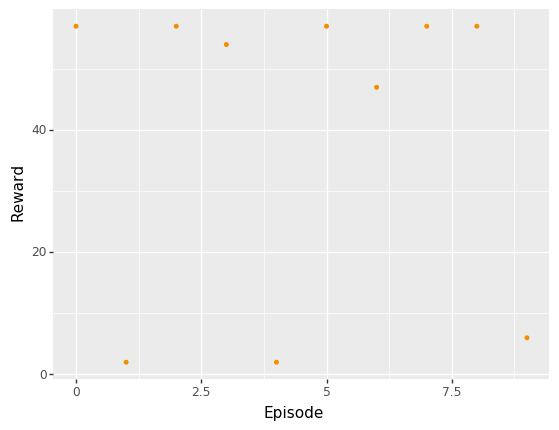

<ggplot: (161568264554)>

In [10]:
ggplot(df_test, aes(x='Episode',y='Reward'))+ \
  geom_point(color="#F18F01", size=1)

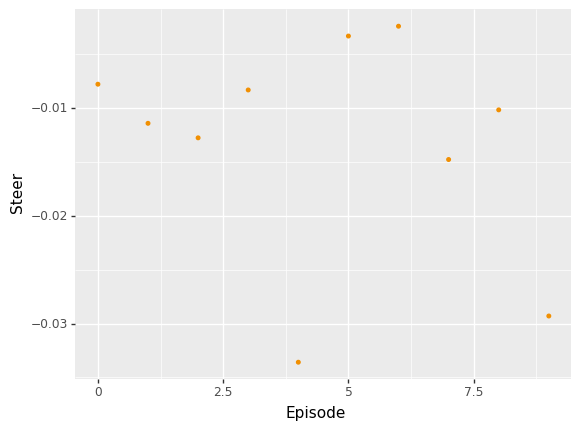

<ggplot: (161531948587)>

In [11]:
ggplot(df_test, aes(x='Episode',y='Steer'))+ \
  geom_point(color="#F18F01", size=1)

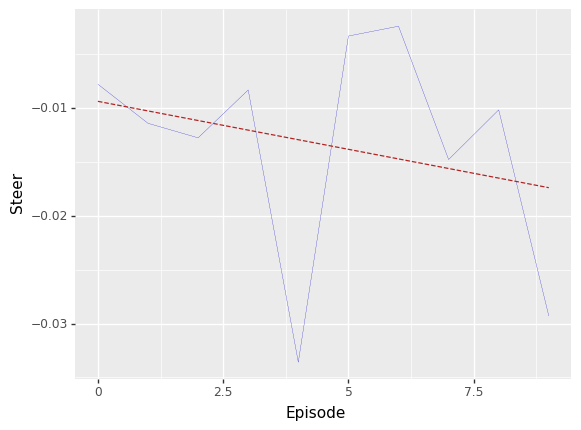

<ggplot: (161568797153)>

In [12]:
ggplot(df_test, aes(x='Episode',y='Steer'))+ \
  geom_line(size=0.1,color='mediumblue') +\
    geom_smooth(method="lm",color='firebrick', se=False, size=0.5, linetype="dashed")

In [13]:
close_carla()